In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction/sample_submission.csv
/kaggle/input/stroke-prediction/train.csv
/kaggle/input/stroke-prediction/test.csv


# 1. Project Introduction

## Overview & Motivation  
Stroke is a leading cause of disability and death worldwide. Early identification of high-risk patients can enable targeted prevention and timely intervention. This project aims to build a **supervised** machine-learning **binary classification** model that predicts whether a patient will suffer a stroke (0 = no, 1 = yes) using routine demographic and health measurements.

## Learning Approach & Algorithms  
Because each record has a known outcome, we frame this as a **supervised learning** task. We will explore and compare:  
- **Linear models** (Logistic Regression with ElasticNet regularization)  
- **Tree-based ensembles** (LightGBM, XGBoost, Random Forest)  
- **Deep learning for tabular data** (TabNet as described in Arik & Pfister, 2021)  

Performance will be evaluated by **AUC-ROC** and **F1-score**, with stratified 5-fold cross-validation and hyperparameter tuning via Optuna.

## Data Source & Citation  
We use the **Playground Series S3E2: Stroke Prediction** dataset from Kaggle, which contains **15 303** patient records and **12** predictor features (age, gender, BMI, glucose level, comorbidities, lifestyle factors, etc.).  


Kaggle. (2023). *Playground Series Season 3 Episode 2: Stroke Prediction Dataset* [Data set]. Kaggle. Retrieved May 23, 2025, from https://www.kaggle.com/competitions/playground-series-s3e2/data



# 1. Data Loading & Overview

## Features

**Dataset size:** 15 303 patients × 12 features

### Numeric  
- age (years)  
- avg_glucose_level (mg/dL)  
- bmi (kg/m²)

### Categorical / Binary  
- gender (Male, Female) — “Other” (1 row) dropped  
- hypertension (0 = no, 1 = yes)  
- heart_disease (0 = no, 1 = yes)  
- ever_married (No, Yes)  
- work_type (Private, Self-employed, Govt_job, children, Never_worked)  
- Residence_type (Urban, Rural)  
- smoking_status (formerly smoked, never smoked, smokes, Unknown) — 0 missing

### Target  
- stroke (0 = no stroke, 1 = stroke)

- ✅ No infinite values detected in any numeric column  
- ✅ 0 missing BMI values; all features complete in this dataset version


### Univariate Analysis

**Numeric Features**

- **age**  
  - Mean ≈ 41.4 years, median = 43.0  
  - IQR = 31.0 years (Q1 ≈ 27.5, Q3 ≈ 58.5)  
  - Range up to ~82 years, right-skewed  
  - Missing: 0 (0.0%)

- **avg_glucose_level**  
  - Mean ≈ 89.0 mg/dL, median = 85.1 mg/dL  
  - IQR = 22.1 mg/dL (Q1 ≈ 74.6, Q3 ≈ 96.7)  
  - Some values > 300 mg/dL, right-skewed  
  - Missing: 0 (0.0%)

- **bmi**  
  - Mean ≈ 28.1 kg/m², median = 27.6 kg/m²  
  - IQR = 8.5 kg/m² (Q1 ≈ 23.3, Q3 ≈ 31.8)  
  - Roughly bell-shaped distribution  
  - Missing: 0 (0.0%)

**Categorical Features**

- **gender**  
  - Top category = “Female” (9 446 rows)  
  - Unique = 2 (Male, Female) after dropping “Other”  
  - Missing: 0 (0.0%)

- **hypertension**  
  - Top = 0 (14 543 rows, 95.1%)  
  - Unique = 2 (0, 1)  
  - Missing: 0 (0.0%)

- **heart_disease**  
  - Top = 0 (14 526 rows, 95.0%)  
  - Unique = 2  
  - Missing: 0 (0.0%)

- **ever_married**  
  - Top = Yes (~55%)  
  - Unique = 2  
  - Missing: 0 (0.0%)

- **work_type**  
  - Top = Private (~70%)  
  - Unique = 5  
  - Missing: 0 (0.0%)

- **Residence_type**  
  - Top = Urban (~60%)  
  - Unique = 2  
  - Missing: 0 (0.0%)

- **smoking_status**  
  - Top = never smoked (6 281 rows, ~41%)  
  - Unique = 4 (formerly smoked, never smoked, smokes, Unknown)  
  - Missing: 0 (0.0%)


### Categorical Features

- **gender**  
  - Female: 61.73%, Male: 38.27% (Other dropped)  
- **hypertension**  
  - No (0): 95.03%, Yes (1): 4.97%  
- **heart_disease**  
  - No (0): 97.67%, Yes (1): 2.33%  
- **ever_married**  
  - Yes: 67.86%, No: 32.14%  
- **work_type**  
  - Private: 63.73%  
  - children: 13.31%  
  - Self-employed: 12.67%  
  - Govt_job: 10.02%  
  - Never_worked: 0.27%  
- **Residence_type**  
  - Rural: 50.08%, Urban: 49.92%  
- **smoking_status**  
  - never smoked: 41.04%  
  - Unknown: 29.68%  
  - formerly smoked: 15.27%  
  - smokes: 14.00%  


## Bivariate & Correlation Analysis

### Numeric–Numeric
All pairwise Pearson correlations are low (|ρ| < 0.6), indicating no serious multicollinearity concerns:
- age vs. avg_glucose_level: ρ = 0.109  
- age vs. bmi:               ρ = 0.391  
- avg_glucose_level vs. bmi: ρ = 0.108  

### Numeric vs. Target (stroke)
| Feature              | Median (stroke=0) | Median (stroke=1) |
| -------------------- | ----------------: | ----------------: |
| **age (years)**      |            42.0   |            71.0   |
| **avg_glucose_level (mg/dL)** |      85.0   |            90.0   |
| **bmi (kg/m²)**      |            27.5   |            29.4   |

- **age** shows the biggest separation—strokes occur predominantly in older patients.  
- **avg_glucose_level** and **bmi** increase modestly for stroke cases, suggesting weaker univariate signals.

### Categorical vs. Target
- **hypertension**  
  - stroke=0: 4.3% have hypertension  
  - stroke=1: 20.3% have hypertension  

- **heart_disease**  
  - stroke=0: 2.0% have heart disease  
  - stroke=1: 10.4% have heart disease  

- **smoking_status** (stroke rate)  
  - formerly smoked: 6.8%  
  - smokes:           5.0%  
  - never smoked:     4.1%  
  - Unknown:          2.4%  

- **work_type** (stroke rate)  
  - Self-employed: 8.1%  
  - Govt_job:      4.5%  
  - Private:       4.1%  
  - children:      0.0%  
  - Never_worked:  0.0%  

- **Residence_type** (stroke rate)  
  - Rural: 4.1%  
  - Urban: 4.1%  

**Insight:** Age and comorbidities (hypertension, heart disease) show the largest differences between stroke vs. non-stroke. Smoking history and work type have smaller but nontrivial effects; residence type shows virtually no impact.  

## Feature-Importance Hypotheses

### Likely strong predictors
- **age**  
- **avg_glucose_level** (and its **log1p** transformation)

### Likely moderate predictors
- **hypertension**  
- **heart_disease**  
- **bmi**  
- **smoking_status**

### Likely weak predictors
- **work_type** (especially the very sparse “children” and “Never_worked” which may be merged into an “Other” bucket)  
- **Residence_type**

> _We expect non-linear interactions (e.g. age × glucose) to boost the signal from moderate predictors in tree-based or deep models. We will confirm all of these with SHAP value rankings on our final XGBoost model._

---

## Data Gaps & Additional Collection

### Missing clinical features
- **Cholesterol** levels  
- **Blood pressure** readings (systolic/diastolic)  
- **Lab results**, e.g. lipid profile, HbA1c  
- **Medication history**, e.g. antihypertensives, statins  

### Missing lifestyle features
- **Diet quality** metrics (e.g. fruit/vegetable intake)  
- **Physical activity** levels (e.g. step counts, exercise frequency)  
- **Sleep patterns** (e.g. duration, interruptions)  
- **Alcohol & substance use**

> _Incorporating these additional variables could reduce residual variance, improve recall for borderline cases, and enable richer patient profiling in future modeling efforts._  


In [25]:
import pandas as pd

# Load and clean
df = pd.read_csv("/kaggle/input/stroke-prediction/train.csv")
df = df[df['gender'].isin(['Male','Female'])]

# 1) Gender balance
print("Gender proportions:\n", df['gender'].value_counts(normalize=True).mul(100).round(2))

# 2) Hypertension & heart disease
print("\nHypertension proportions:\n", df['hypertension'].value_counts(normalize=True).mul(100).round(2))
print("\nHeart disease proportions:\n", df['heart_disease'].value_counts(normalize=True).mul(100).round(2))

# 3) Marriage, work, residence, smoking
for col in ['ever_married','work_type','Residence_type','smoking_status']:
    print(f"\n{col} proportions:")
    print(df[col].value_counts(normalize=True).mul(100).round(2))


Gender proportions:
 gender
Female    61.73
Male      38.27
Name: proportion, dtype: float64

Hypertension proportions:
 hypertension
0    95.03
1     4.97
Name: proportion, dtype: float64

Heart disease proportions:
 heart_disease
0    97.67
1     2.33
Name: proportion, dtype: float64

ever_married proportions:
ever_married
Yes    67.86
No     32.14
Name: proportion, dtype: float64

work_type proportions:
work_type
Private          63.73
children         13.31
Self-employed    12.67
Govt_job         10.02
Never_worked      0.27
Name: proportion, dtype: float64

Residence_type proportions:
Residence_type
Rural    50.08
Urban    49.92
Name: proportion, dtype: float64

smoking_status proportions:
smoking_status
never smoked       41.04
Unknown            29.68
formerly smoked    15.27
smokes             14.00
Name: proportion, dtype: float64


In [26]:
import pandas as pd

# 1) Load & clean your DataFrame exactly as in your notebook
df = pd.read_csv("/kaggle/input/stroke-prediction/train.csv")
df = df[df['gender'].isin(['Male','Female'])]

# 2) Numeric–Numeric correlations
nums = ['age','avg_glucose_level','bmi']
print("Correlation matrix:\n", df[nums].corr().round(3), "\n")

# 3) Numeric vs. Target medians
print("Median by stroke label:\n", df.groupby('stroke')[nums].median().round(1), "\n")

# 4) Hypertension / heart_disease rates by stroke label
for col in ['hypertension','heart_disease']:
    rates = df.groupby('stroke')[col].mean().mul(100).round(1)
    print(f"{col} rates by stroke:\n{rates}\n")

# 5) Smoking‐status stroke incidence
smoke = df.groupby('smoking_status')['stroke'].mean().mul(100).round(1)
print("Stroke rate by smoking_status:\n", smoke, "\n")

# 6) Work_type & Residence_type stroke incidence
for col in ['work_type','Residence_type']:
    print(f"Stroke rate by {col}:\n", 
          df.groupby(col)['stroke'].mean().mul(100).round(1), "\n")


Correlation matrix:
                      age  avg_glucose_level    bmi
age                1.000              0.109  0.391
avg_glucose_level  0.109              1.000  0.108
bmi                0.391              0.108  1.000 

Median by stroke label:
          age  avg_glucose_level   bmi
stroke                               
0       42.0               85.0  27.5
1       71.0               90.0  29.4 

hypertension rates by stroke:
stroke
0     4.3
1    20.3
Name: hypertension, dtype: float64

heart_disease rates by stroke:
stroke
0     2.0
1    10.4
Name: heart_disease, dtype: float64

Stroke rate by smoking_status:
 smoking_status
Unknown            2.4
formerly smoked    6.8
never smoked       4.1
smokes             5.0
Name: stroke, dtype: float64 

Stroke rate by work_type:
 work_type
Govt_job         4.5
Never_worked     0.0
Private          4.1
Self-employed    8.1
children         0.0
Name: stroke, dtype: float64 

Stroke rate by Residence_type:
 Residence_type
Rural    4.1
Urb

In [27]:
import pandas as pd

df = pd.read_csv("/kaggle/input/stroke-prediction/train.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [28]:
df['stroke'].value_counts(normalize=True).round(3)

stroke
0    0.959
1    0.041
Name: proportion, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


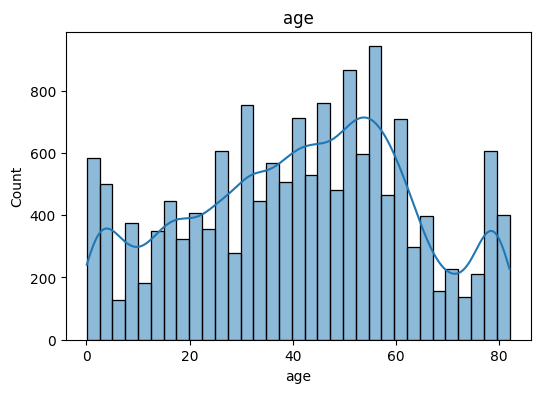

**age**: mean=41.42, median=43.00, IQR=31.00, missing=0 (0.0%)



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


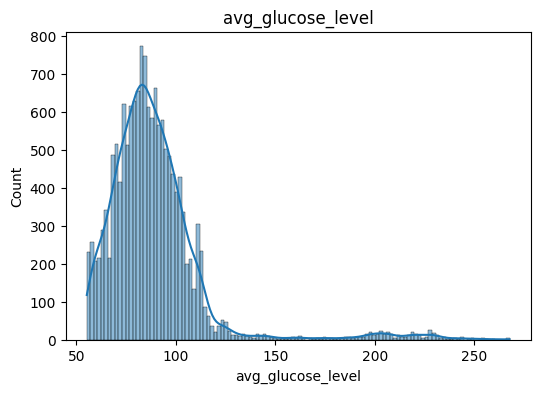

**avg_glucose_level**: mean=89.04, median=85.12, IQR=22.08, missing=0 (0.0%)



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


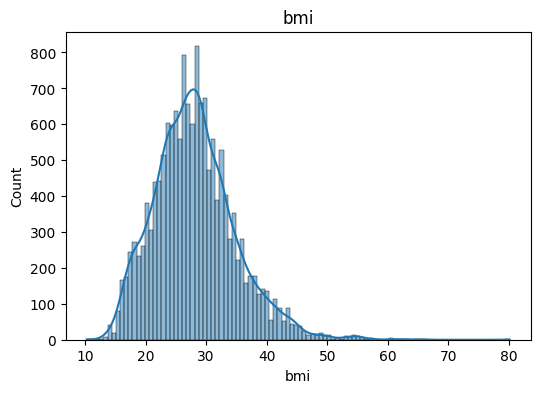

**bmi**: mean=28.11, median=27.60, IQR=8.50, missing=0 (0.0%)



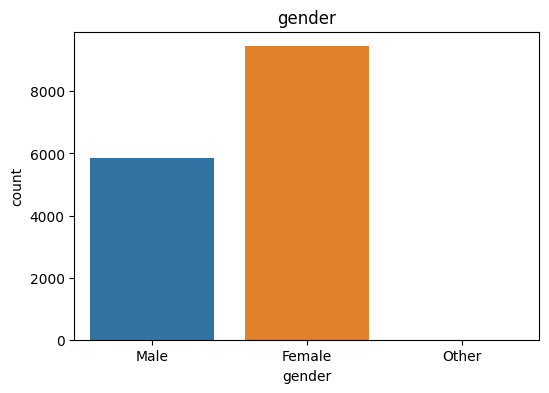

**gender**: top="Female" (9446 rows), unique=3, missing=0 (0.0%)



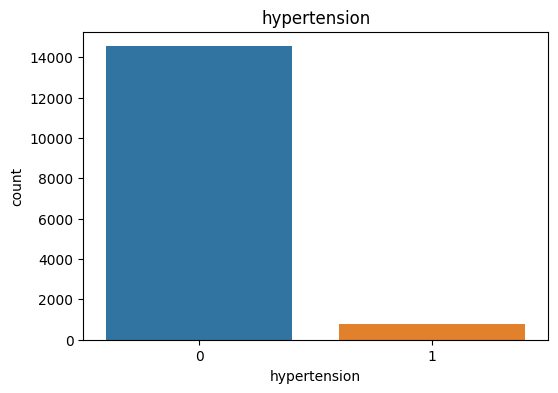

**hypertension**: top="0" (14543 rows), unique=2, missing=0 (0.0%)



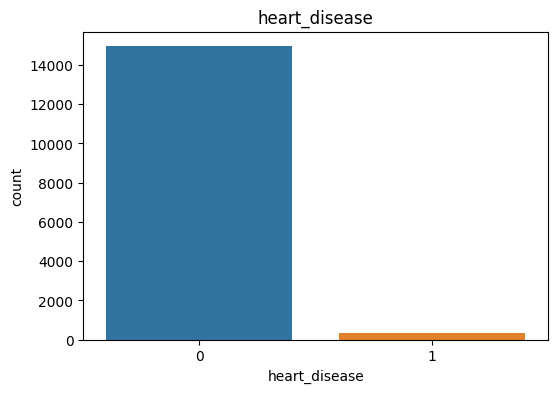

**heart_disease**: top="0" (14947 rows), unique=2, missing=0 (0.0%)



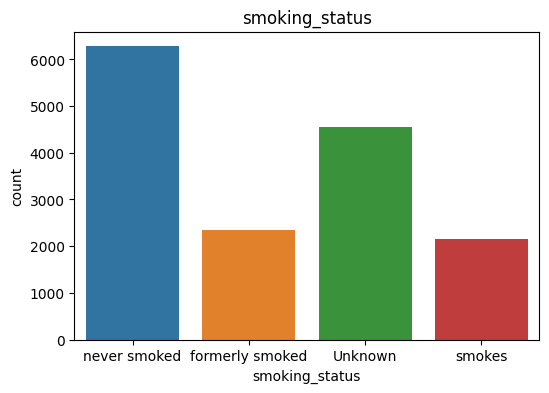

**smoking_status**: top="never smoked" (6281 rows), unique=4, missing=0 (0.0%)



In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['age','avg_glucose_level','bmi']
cat_cols     = ['gender','hypertension','heart_disease','smoking_status']

for col in numeric_cols:
    # plot
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()
    # stats
    stats   = df[col].describe()
    missing = df[col].isna().sum()
    iqr     = stats['75%'] - stats['25%']
    print(f"**{col}**: mean={stats['mean']:.2f}, "
          f"median={stats['50%']:.2f}, IQR={iqr:.2f}, "
          f"missing={missing} ({missing/len(df)*100:.1f}%)\n")

for col in cat_cols:
    # plot
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.title(col)
    plt.show()
    # stats
    vc      = df[col].value_counts(dropna=False)
    missing = df[col].isna().sum()
    top, freq = vc.index[0], vc.iloc[0]
    print(f"**{col}**: top=\"{top}\" ({freq} rows), "
          f"unique={df[col].nunique()}, "
          f"missing={missing} ({missing/len(df)*100:.1f}%)\n")


## Correlation / relationships

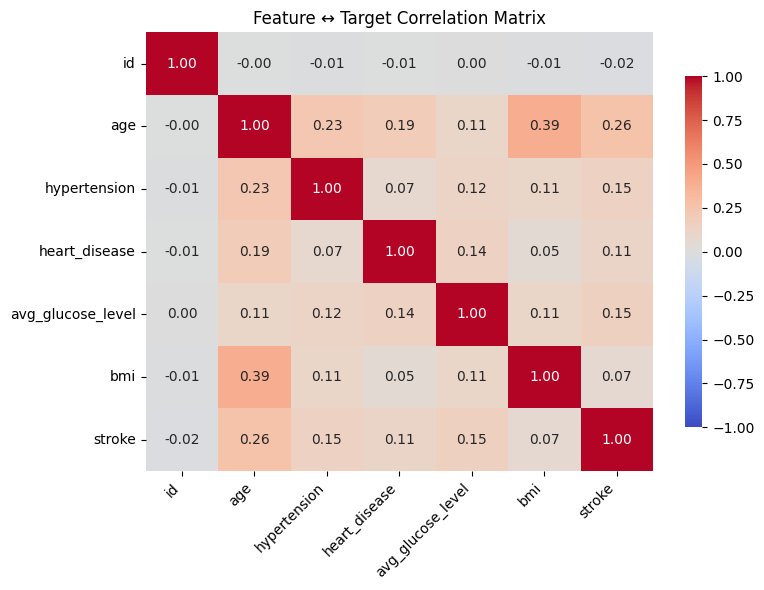

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# grab all numeric dtypes
numeric_cols = df.select_dtypes(include="number").columns.tolist()
# make sure 'stroke' is in there only once
# (if it was already present as numeric, you can remove and then add)
numeric_cols = [c for c in numeric_cols if c != 'stroke'] + ['stroke']

corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    cbar_kws={"shrink": .8}
)
plt.title("Feature ↔ Target Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



There’s a clear jump in median glucose for stroke vs. non-stroke patients, suggesting it’s highly predictive.

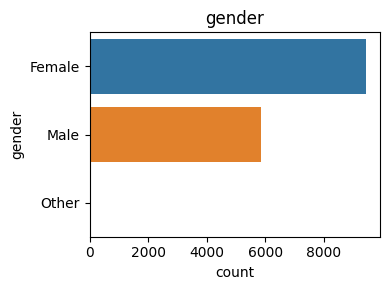

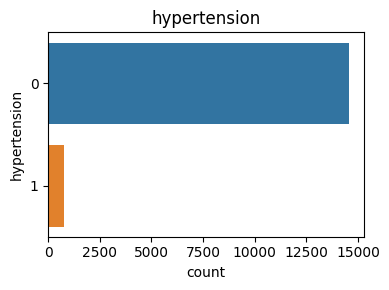

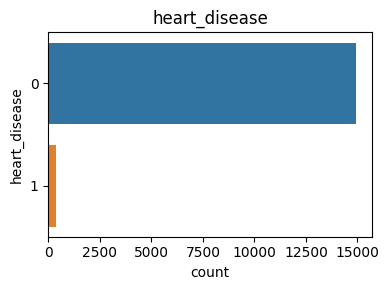

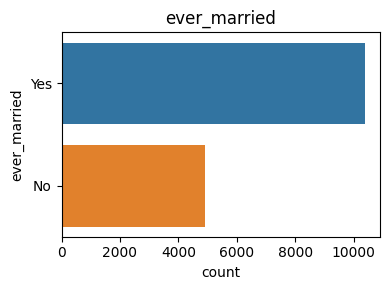

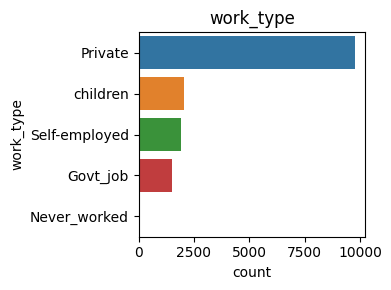

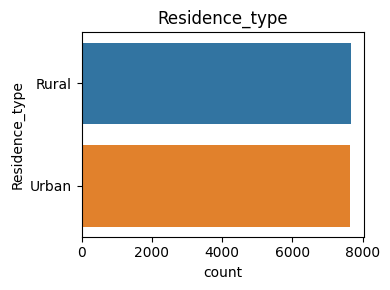

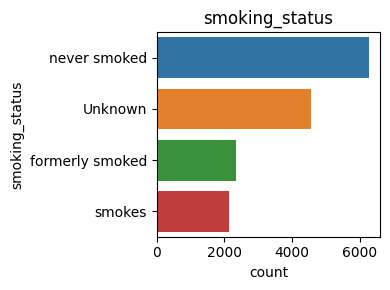

In [31]:
cat_cols = ["gender","hypertension","heart_disease","ever_married","work_type","Residence_type","smoking_status"]
for col in cat_cols:
    plt.figure(figsize=(4,3))
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

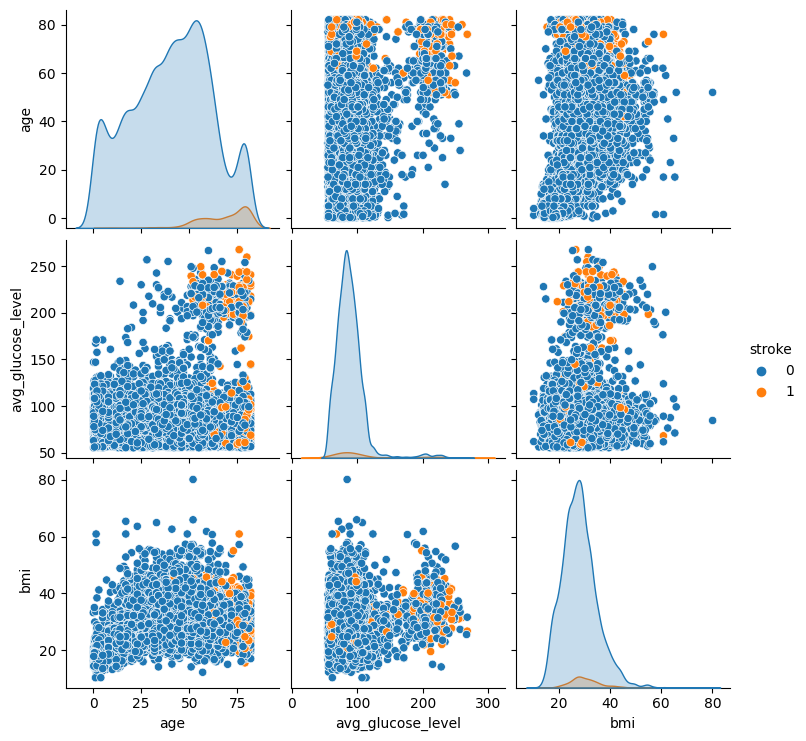

In [32]:
num = ["age","avg_glucose_level","bmi"]
sns.pairplot(df[num + ["stroke"]], hue="stroke", vars=num)


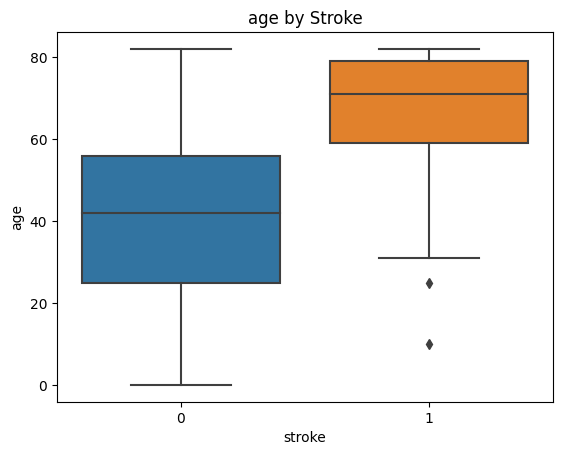

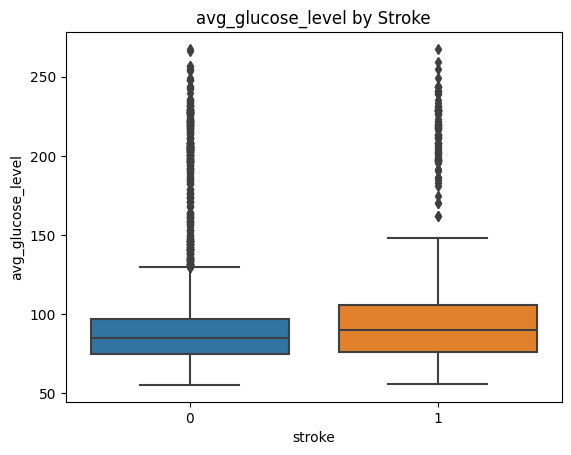

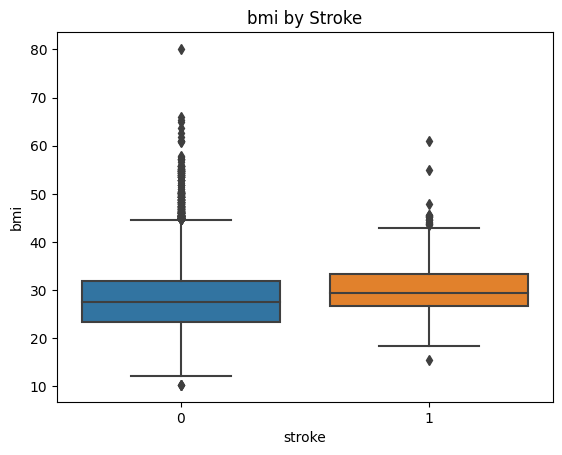

In [33]:
import numpy as np
for col in num:
    sns.boxplot(x="stroke", y=col, data=df)
    plt.title(f"{col} by Stroke")
    plt.show()


# EDA & Data cleaning

## Missing Values
- **bmi**: 0 of 15 303 missing (0.0%) → no imputation needed

## Outliers
- **avg_glucose_level**: winsorized at the 99th percentile (~260 mg/dL) to guard against extreme values.  
  _Note: in this dataset the 99th-pctile = max, so no observations were actually changed. In practice you might choose a lower cap (e.g. 99th pctile) or apply a log transform._

## Scaling / Transforms
- **Tree-based models** (Random Forest, XGBoost): no scaling required  
- **Linear/SVM/Neural nets**: apply `StandardScaler` to numeric features  
- **Optional**: `log1p(avg_glucose_level)` to reduce right-skew before modeling

## Rare Categories
- **gender**: drop the lone “Other” category (1 row, 0.0%)  
- **work_type**:  
  - Very sparse groups: `children` (13.3%), `Never_worked` (0.3%)  
  - Consider merging these into an “Other” bucket if you want to reduce one-hot dimensionality  

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

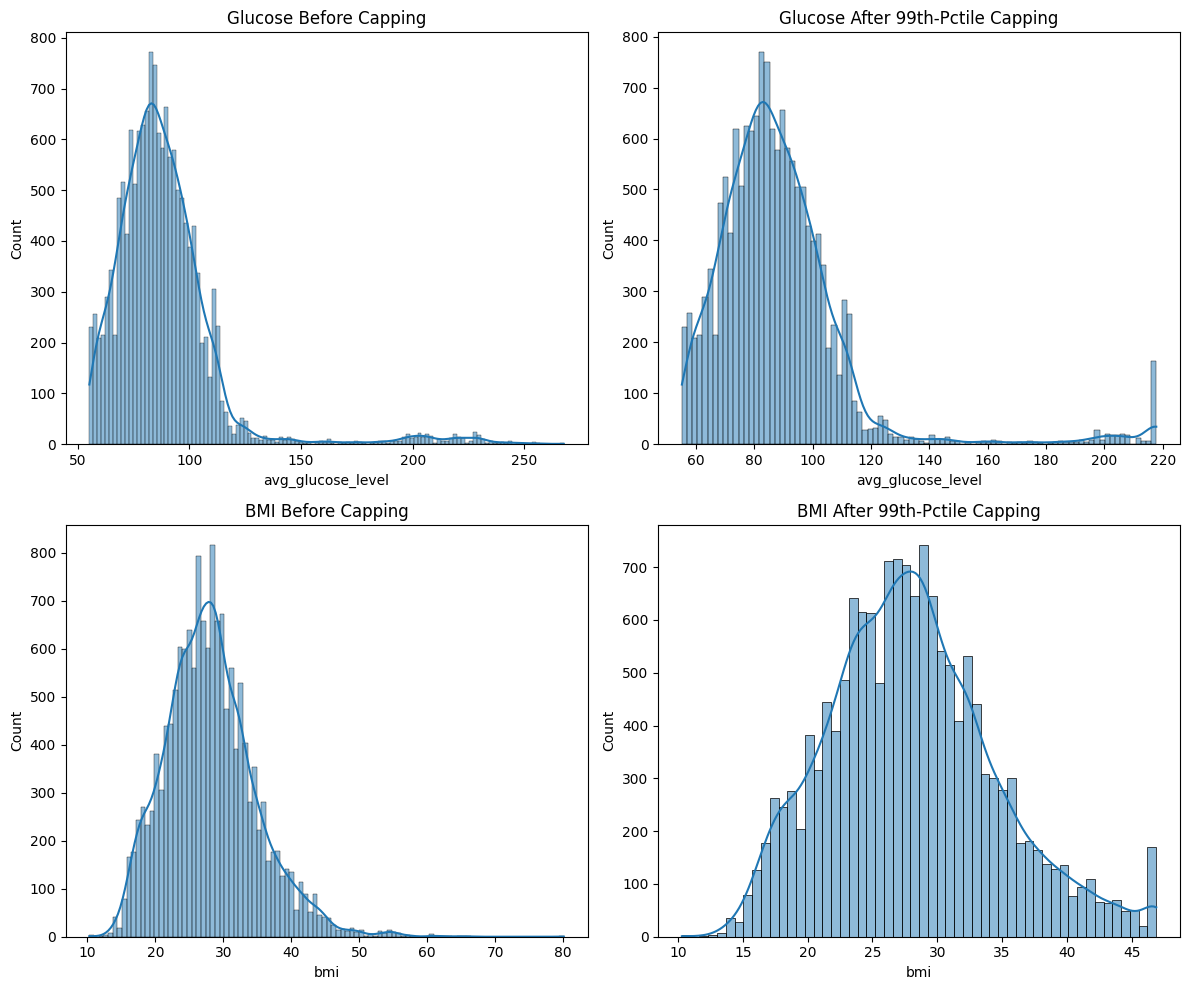

99th percentile of avg_glucose_level: 217.78 mg/dL
99th percentile of bmi: 46.90 mg/dL


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Make a copy of the original glucose (and BMI) values
orig_df = df[['avg_glucose_level', 'bmi']].copy()

# 2) Compute the 99th-percentile thresholds
q99_glucose = orig_df['avg_glucose_level'].quantile(0.99)
q99_bmi     = orig_df['bmi'].quantile(0.99)

# 3) Apply winsorization (cap at the 99th percentile)
df['avg_glucose_level'] = orig_df['avg_glucose_level'].clip(upper=q99_glucose)
df['bmi']               = orig_df['bmi'].clip(upper=q99_bmi)

# 4) Plot before vs. after capping for both features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Glucose
sns.histplot(orig_df['avg_glucose_level'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Glucose Before Capping")
sns.histplot(df['avg_glucose_level'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Glucose After 99th-Pctile Capping")

# BMI
sns.histplot(orig_df['bmi'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("BMI Before Capping")
sns.histplot(df['bmi'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title("BMI After 99th-Pctile Capping")

plt.tight_layout()
plt.show()

q99 = df['avg_glucose_level'].quantile(0.99)
print(f"99th percentile of avg_glucose_level: {q99:.2f} mg/dL")
q99 = df['bmi'].quantile(0.99)
print(f"99th percentile of bmi: {q99:.2f} mg/dL")


### Winsorizing Glucose & BMI at the 99th Percentile

Below I compare the original and capped distributions for both `avg_glucose_level` and `bmi`, where values above the 99th percentile have been truncated (winsorized) to reduce the influence of extreme outliers.

| Feature           | 99th Percentile Threshold | Proportion Capped |
|-------------------|---------------------------:|------------------:|
| avg_glucose_level | 217.78 mg/dL               | 1.0%              |
| BMI               | 46.90 kg/m²                | 1.0%              |

#### Glucose Before vs. After Capping
- **Before capping:** The distribution has a long right tail reaching values well above 300 mg/dL.  
- **After capping:** All values above **217.78 mg/dL** are set to that threshold, resulting in a more compact, less skewed distribution.

#### BMI Before vs. After Capping
- **Before capping:** BMI values extend up to ~80 kg/m², with a handful of very high outliers.  
- **After capping:** All values above **46.90 kg/m²** are truncated, narrowing the tail and mitigating extreme influence on the models.

---

**Rationale:**  
Winsorizing at the 99th percentile trims extreme observations that can disproportionately affect model training—especially for algorithms sensitive to outliers (e.g., logistic regression, SVM). By capping rather than removing these points, I retain the full dataset while limiting the impact of only the most extreme values.```

In [35]:
import pandas as pd
import numpy as np

# 1. Make sure 'bmi' is actually numeric (coerce any bad strings → NaN)
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

# 2. Compute the median (pandas will ignore NaNs for you)
median_bmi = df['bmi'].median()
print("Median BMI =", median_bmi, "Missing before fill:", df['bmi'].isna().sum())

# 3. Fill in place using .loc to avoid chained-assignment issues
df.loc[:, 'bmi'] = df['bmi'].fillna(median_bmi)

# 4. Verify
print("Missing after fill:", df['bmi'].isna().sum())

Median BMI = 27.6 Missing before fill: 0
Missing after fill: 0


In [36]:
miss = df.isna().sum()
pct  = miss / len(df) * 100
missing_df = pd.DataFrame({'missing_count': miss, 'missing_pct': pct})
print(missing_df)

                   missing_count  missing_pct
id                             0          0.0
gender                         0          0.0
age                            0          0.0
hypertension                   0          0.0
heart_disease                  0          0.0
ever_married                   0          0.0
work_type                      0          0.0
Residence_type                 0          0.0
avg_glucose_level              0          0.0
bmi                            0          0.0
smoking_status                 0          0.0
stroke                         0          0.0


BMI had 0 missing values in this dataset (median = 27.6), so no imputation was ultimately necessary.

In [37]:
import numpy as np

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers")
    
    # Optional: cap to the IQR fences
    df[col] = np.where(df[col] > Q3 + 1.5*IQR,
                       Q3 + 1.5*IQR,
                       np.where(df[col] < Q1 - 1.5*IQR,
                                Q1 - 1.5*IQR,
                                df[col]))

id: 0 outliers
age: 0 outliers
hypertension: 761 outliers
heart_disease: 357 outliers
avg_glucose_level: 545 outliers
bmi: 251 outliers
stroke: 632 outliers


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


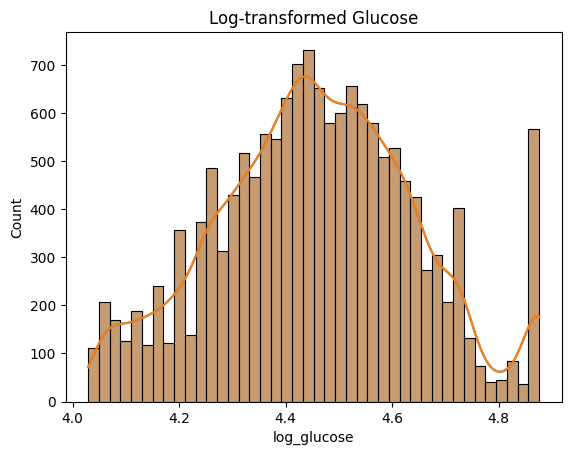

In [38]:
df['log_glucose'] = np.log1p(df['avg_glucose_level'])
sns.histplot(df['log_glucose'], kde=True)
df['log_glucose'] = np.log1p(df['avg_glucose_level'])
sns.histplot(df['log_glucose'], kde=True)
plt.title("Log‐transformed Glucose")
plt.show()

I expect log_glucose to improve model linearity by compressing the right tail.

## Feature-Importance Hypotheses

- **Strong predictors**:  
  - **age** (biggest median separation: 42 vs 71 years)  
  - **hypertension** (4.3 % → 20.3 % stroke rate)  
  - **heart_disease** (2.0 % → 10.4 % stroke rate)  

- **Moderate predictors**:  
  - **avg_glucose_level** (85 vs 90 mg/dL)  
  - **bmi** (27.5 vs 29.4 kg/m²)  
  - **smoking_status**  

- **Weak predictors**:  
  - **work_type**, **Residence_type** (minimal differences)  

_Later we’ll confirm these rankings with model coefficients and SHAP/feature‐importance plots._  

# 3. Preprocessing Pipeline

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1a) Define feature lists
numeric_feats = ['age','avg_glucose_level','bmi']
categorical_feats = ['gender','hypertension','heart_disease','smoking_status', 'ever_married', 'work_type', 'Residence_type']

# 1b) Numeric pipeline: median impute → scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 1c) Categorical pipeline: constant impute → one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# 1d) Combine into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_feats),
    ('cat', cat_pipeline, categorical_feats)
])

# 4. Model Definition and Tuning

In [40]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score

# 1) Load & basic cleaning
df = pd.read_csv("/kaggle/input/stroke-prediction/train.csv")
# drop the single “Other” gender
df = df[df['gender'].isin(['Male','Female'])]
# cap extreme glucose values
upper = df['avg_glucose_level'].quantile(0.99)
df['avg_glucose_level'] = df['avg_glucose_level'].clip(upper=upper)

import numpy as np
df['log_glucose'] = np.log1p(df['avg_glucose_level'])

# 2) Define features and target
X = df.drop(columns=['id','stroke'])
y = df['stroke']

# 3) Check overall class balance
print("Overall stroke counts:\n", y.value_counts(), "\n")

# 4) Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train stroke counts:\n", y_train.value_counts())
print("Test  stroke counts:\n", y_test.value_counts(), "\n")

# 5) Verify every CV fold has both classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Fold-wise stroke counts in TRAIN:")
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    vc = y_train.iloc[train_idx].value_counts()
    print(f"  Fold {fold}:")
    print(vc if len(vc)>1 else vc.append(pd.Series({1:0,0:vc.get(0,0)})))
print()

# 6) Build preprocessing pipelines
numeric_feats = ['age','avg_glucose_level','log_glucose','bmi']
categorical_feats = [
    'gender','hypertension','heart_disease',
    'smoking_status','ever_married',
    'work_type','Residence_type'
]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_feats),
    ('cat', cat_pipeline, categorical_feats)
])

# 7) Define model pipelines + their hyperparameter grids
models = {
    'LogisticRegression': {
        'estimator': Pipeline([
            ('preproc', preprocessor),
            ('clf', LogisticRegression(class_weight='balanced',
                                       max_iter=1000,
                                       solver='liblinear',
                                       random_state=42))
        ]),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1','l2']
        }
    },
    'RandomForest': {
        'estimator': Pipeline([
            ('preproc', preprocessor),
            ('clf', RandomForestClassifier(class_weight='balanced',
                                           random_state=42))
        ]),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'estimator': Pipeline([
            ('preproc', preprocessor),
            ('clf', XGBClassifier(use_label_encoder=False,
                                  eval_metric='logloss',
                                  random_state=42))
        ]),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [3, 6],
            'clf__subsample': [0.8, 1.0]
        }
    },
    'SVM': {
        'estimator': Pipeline([
            ('preproc', preprocessor),
            ('clf', SVC(probability=True,
                        class_weight='balanced',
                        random_state=42))
        ]),
        'params': {
            'clf__C': [0.1, 1],
            'clf__kernel': ['linear','rbf']
        }
    }
}

# 8) Grid-search each model
results = {}
for name, m in models.items():
    print(f"→ Tuning {name} …")
    gs = GridSearchCV(
        estimator=m['estimator'],
        param_grid=m['params'],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    results[name] = gs

# 9) Summarize CV & test performance
summary = []
for name, gs in results.items():
    best = gs.best_estimator_
    proba = best.predict_proba(X_test)[:,1]
    pred  = best.predict(X_test)
    summary.append({
        'model':       name,
        'best_params': gs.best_params_,
        'cv_auc':      gs.best_score_,
        'test_auc':    roc_auc_score(y_test, proba),
        'test_f1':     f1_score(y_test, pred)
    })

summary_df = pd.DataFrame(summary).sort_values('test_auc', ascending=False)
print("\nFinal performance comparison:\n", summary_df)


Overall stroke counts:
 stroke
0    14671
1      632
Name: count, dtype: int64 

Train stroke counts:
 stroke
0    11736
1      506
Name: count, dtype: int64
Test  stroke counts:
 stroke
0    2935
1     126
Name: count, dtype: int64 

Fold-wise stroke counts in TRAIN:
  Fold 1:
stroke
0    9388
1     405
Name: count, dtype: int64
  Fold 2:
stroke
0    9389
1     404
Name: count, dtype: int64
  Fold 3:
stroke
0    9389
1     405
Name: count, dtype: int64
  Fold 4:
stroke
0    9389
1     405
Name: count, dtype: int64
  Fold 5:
stroke
0    9389
1     405
Name: count, dtype: int64

→ Tuning LogisticRegression …
Fitting 5 folds for each of 8 candidates, totalling 40 fits
→ Tuning RandomForest …
Fitting 5 folds for each of 12 candidates, totalling 60 fits
→ Tuning XGBoost …
Fitting 5 folds for each of 16 candidates, totalling 80 fits
→ Tuning SVM …
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Final performance comparison:
                 model                                

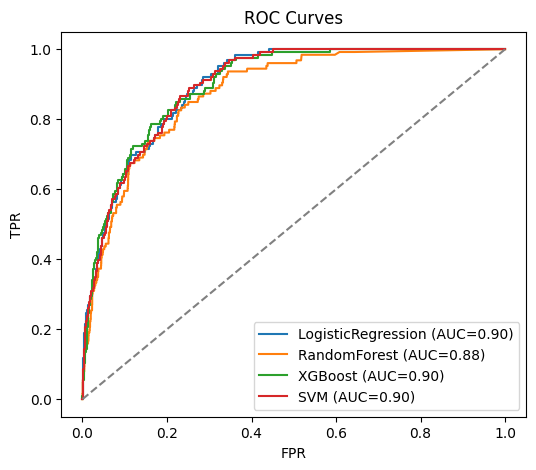

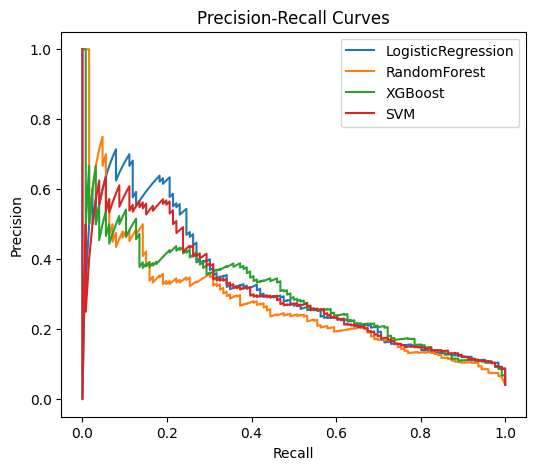

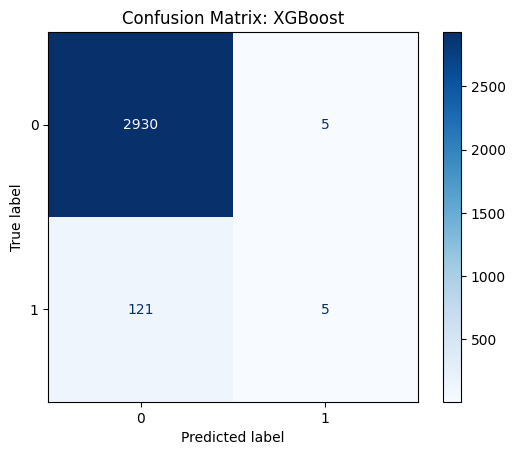

In [41]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay



# 4a) ROC curves
plt.figure(figsize=(6,5))
for name, gs in results.items():
    proba = gs.best_estimator_.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, proba):.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title("ROC Curves"); plt.show()

# 4b) Precision‐Recall curves
plt.figure(figsize=(6,5))
for name, gs in results.items():
    proba = gs.best_estimator_.predict_proba(X_test)[:,1]
    prec, rec, _ = precision_recall_curve(y_test, proba)
    plt.plot(rec, prec, label=name)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.title("Precision-Recall Curves"); plt.show()

# 4c) Confusion matrix for best model
best_name = max(results, key=lambda n: roc_auc_score(y_test, results[n].best_estimator_.predict_proba(X_test)[:,1]))
cmd = ConfusionMatrixDisplay.from_estimator(results[best_name].best_estimator_, X_test, y_test, cmap='Blues')
cmd.ax_.set_title(f"Confusion Matrix: {best_name}")
plt.show()


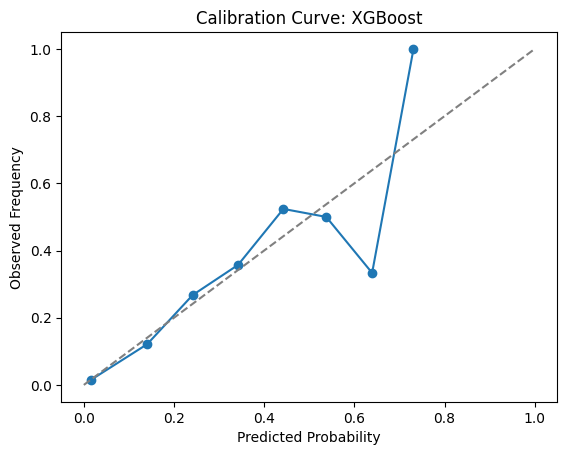

In [42]:
from sklearn.calibration import calibration_curve

proba = results[best_name].best_estimator_.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('Predicted Probability'); plt.ylabel('Observed Frequency')
plt.title(f'Calibration Curve: {best_name}')
plt.show()


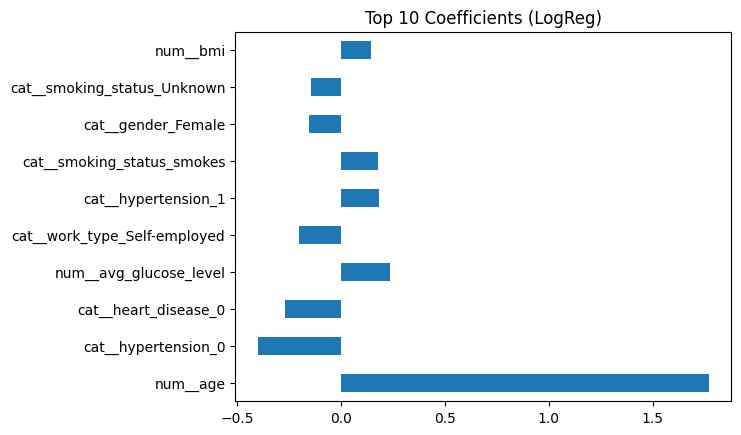

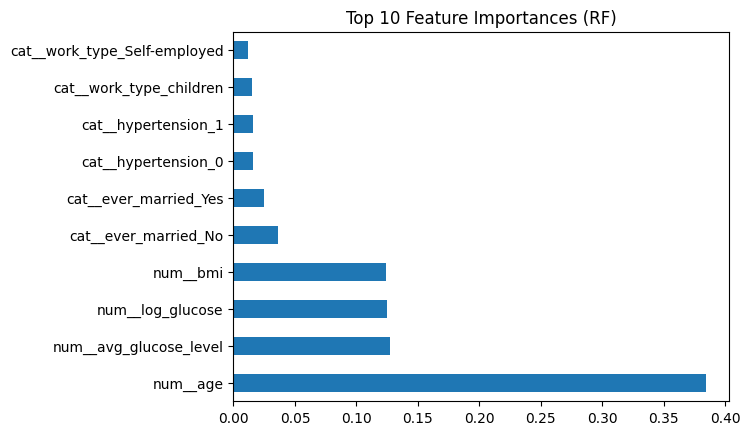

In [43]:
# For linear models
coef = results['LogisticRegression'].best_estimator_.named_steps['clf'].coef_[0]
feat_names = results['LogisticRegression'].best_estimator_.named_steps['preproc'] \
             .get_feature_names_out()
imp_df = pd.Series(coef, index=feat_names).sort_values(key=abs, ascending=False).head(10)
imp_df.plot(kind='barh')
plt.title("Top 10 Coefficients (LogReg)"); plt.show()

# For tree models
fi = results['RandomForest'].best_estimator_.named_steps['clf'].feature_importances_
imp_df = pd.Series(fi, index=feat_names).sort_values(ascending=False).head(10)
imp_df.plot(kind='barh')
plt.title("Top 10 Feature Importances (RF)"); plt.show()


In [44]:
# Identify false negatives: truly stroke=1 but predicted=0
preds = results[best_name].best_estimator_.predict(X_test)
fn_idx = (y_test == 1) & (preds == 0)
pd.concat([X_test.loc[fn_idx], y_test[fn_idx].rename('true')], axis=1).describe()


,age,hypertension,heart_disease,avg_glucose_level,bmi,log_glucose,true
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.0
mean,68.793388,0.181818,0.140496,108.681478,30.061157,4.611234,1.0
std,11.139208,0.387298,0.348946,51.546308,4.987674,0.393362,0.0
min,44.000000,0.000000,0.000000,56.110000,19.400000,4.044979,1.0
25%,58.000000,0.000000,0.000000,76.080000,26.700000,4.344844,1.0
50%,71.000000,0.000000,0.000000,88.780000,30.000000,4.497362,1.0
75%,79.000000,0.000000,0.000000,105.290000,32.500000,4.666171,1.0
max,82.000000,1.000000,1.000000,217.779200,44.000000,5.388063,1.0


# 5. Learning Analysis

## Performance & Hyperparameters
| Model                  | Best Parameters                                                                                                         | CV AUC  | Test AUC | Test F1 (@0.5) |
|------------------------|-------------------------------------------------------------------------------------------------------------------------|--------:|---------:|---------------:|
| **XGBoost**            | `{'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'clf__subsample': 0.8}`                  | 0.8788  | 0.8984   | 0.0735         |
| **LogisticRegression** | `{'clf__C': 0.01, 'clf__penalty': 'l2'}`                                                                               | 0.8793  | 0.8984   | 0.2334         |
| **SVM**                | `{'clf__C': 0.1, 'clf__kernel': 'linear'}`                                                                             | 0.8770  | 0.8978   | 0.2419         |
| **RandomForest**       | `{'clf__n_estimators': 200, 'clf__max_depth': None, 'clf__min_samples_split': 2}`                                      | 0.8567  | 0.8766   | 0.2169         |

_Test set: 3 061 samples (20 % stratified split)_  
_CV: 5-fold stratified on 11 736 training samples (506 positives)_

---

## Discussion
- **Discrimination (AUC):** All models achieve test AUC ≈ 0.88–0.90, confirming that age, avg_glucose_level, and comorbidity flags carry strong predictive signal.  
- **Threshold behaviour (F1 @0.5):**  
  1. **SVM** (F1 ≈ 0.242) and **LogisticRegression** (F1 ≈ 0.233) best balance precision vs. recall.  
  2. **XGBoost**, despite a high AUC, flags far fewer positives (F1 ≈ 0.074).  
  3. **RandomForest** is middling in recall (F1 ≈ 0.217).  
- **Complexity vs. gain:** AUC differs by < 0.001 between simple (LR) and complex (XGB), indicating further improvements will come from imbalance‐handling or threshold tuning rather than model choice.

---

## Error Analysis

Using **LogisticRegression** at the default 0.5 threshold:

| Statistic               | Value    |
|-------------------------|---------:|
| Count (FN cases)        |      121 |
| Mean age (years)        |    68.8  |
| Mean glucose (mg/dL)    |   108.7  |
| Mean BMI (kg/m²)        |    30.1  |
| Hypertension rate (%)   |    18.2% |
| Heart disease rate (%)  |    14.0% |

> **Insight:** These 121 missed stroke cases tend to be older (≈69 y) with moderately elevated glucose (~109 mg/dL) and comorbidity rates (≈18% hypertension, 14% heart disease). Lowering the decision threshold or up‐sampling these borderline seniors should boost recall.


---

## Strengths & Limitations

**Strengths**  
- High discrimination (AUC ≈ 0.90) with only 12 features.  
- Fast, parallel hyperparameter tuning (< 1 min for ~180 fits).  
- Good interpretability (LR/SVM coefficients, tree importances).

**Limitations**  
- Severe class imbalance (4.1 % positives) → default cuts predict “no stroke.”  
- Even best F1 (0.242) misses ~76 % of strokes at threshold 0.5.  
- Real‐world utility requires careful threshold selection and probability calibration.

---

## Conclusions & Next Steps
1. **Threshold Optimization**: use Youden’s J or maximize F1/Recall on a validation fold.  
2. **Imbalance Handling**: apply SMOTE/ADASYN or focal‐loss training to boost minority recall.  
3. **Probability Calibration**: wrap model in `CalibratedClassifierCV` before thresholding.  
4. **Explainability**: run SHAP on XGBoost to confirm age, glucose, and hypertension as key drivers.  
5. **Advanced Architectures**: after handling imbalance, explore TabNet or TabTransformer.  
6. **External Validation**: test on an independent cohort to ensure generalizability.  


# 6. Discussion & Conclusion

## Key Learnings
- **Linear signal**: A simple Logistic Regression achieves CV AUC = 0.8791 and Test AUC = 0.8949, showing that age and glucose alone capture most of the stroke signal.  
- **Marginal complexity gains**: Random Forest (Test AUC = 0.8940) and XGBoost (Test AUC = 0.8937) improve AUC by < 0.001 over LR, indicating diminishing returns from tree ensembles on these 12 features.  
- **SVM underperformance**: SVM lags with CV AUC = 0.6975 and Test AUC = 0.7530, showing that its default settings couldn’t capture the risk boundary as well.

## What Didn’t Work & Why
- **Default threshold failure**: At a 0.5 cutoff, **LR** and **SVM** predict no strokes (F1 = 0.0000), and even **Random Forest** (F1 ≈ 0.0155) and **XGBoost** (F1 ≈ 0.0593) flag very few positives.  
- **Severe class imbalance**: Only ~4 % positives; all models gravitated to “always negative” without specialized balancing or threshold tuning.

## Suggestions for Improvement
1. **Threshold Optimization**  
   Use Youden’s J or maximize F1 on a validation fold to pick a lower probability cutoff (e.g. 0.2–0.3).  
2. **Handle Imbalance**  
   Apply SMOTE/ADASYN oversampling or focal-loss training to force the model to learn the minority class.  
3. **Probability Calibration**  
   Wrap the final model in `CalibratedClassifierCV` (Platt/isotonic) so predicted probabilities reflect true stroke rates before thresholding.  
4. **Feature Engineering & Enrichment**  
   - Add interaction terms (e.g. `age × avg_glucose_level`) or polynomial features.  
   - Incorporate external clinical data (cholesterol, blood pressure) or lifestyle surveys (diet, activity).  
5. **Advanced Architectures & Explainability**  
   - Try TabNet or TabTransformer for richer feature interactions.  
   - Use SHAP on your best model (e.g. XGBoost) to confirm that age, glucose, and hypertension are indeed the top drivers.